In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from baobab import configs
from baobab.sim_utils import instantiate_PSF_models, get_PSF_model, generate_image, Selection
from baobab.data_augmentation import noise_tf 
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.SimulationAPI.data_api import DataAPI
import lenstronomy.Util.util as util
import emcee
import os

# Testing the Performance of Trained Models

__Author:__ Sebastian Wagner-Carena

__Created:__ 04/01/2020

__Last Run:__ 04/01/2020

__Goals:__ Compare the performance of the BNN model to a forward modeling approach

{'read_noise': 10.0, 'sky_brightness': 20.1, 'ccd_gain': 2.5, 'pixel_scale': 0.08, 'num_exposures': 10, 'background_noise': None, 'exposure_time': 5400.0, 'magnitude_zero_point': 25.9463}


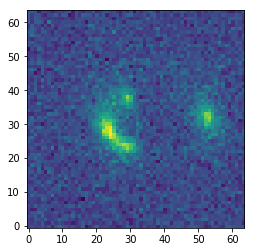

In [4]:
# First we load the image we'll be using to compare to the forward modeling
dataset_root_path = '../datasets/val/'
metadata = pd.read_csv(os.path.join(dataset_root_path,'metadata.csv'))

# We need the baobab config to pull the noise parameters we're going to use
baobab_config_path = '../configs/baobab_configs/val_diagonal.py'


# Specify the image index and load the image
image_i = 30
img_filename = 'X_'+'0'*(6-int(np.log10(image_i)))+str(image_i)+'.npy'
image = np.load(os.path.join(dataset_root_path,img_filename)).astype(np.float32)

# Now we need to add noise to the image
baobab_cfg = configs.BaobabConfig.from_file(baobab_config_path)
noise_kwargs = baobab_cfg.get_noise_kwargs()
print(noise_kwargs)
noise_function = noise_tf.NoiseModelTF(**noise_kwargs)
image = noise_function.add_noise(image).numpy()


# Let's see what we've got
plt.imshow(image,origin='lower')
plt.show()
image_data = metadata[metadata['img_filename'] == img_filename]

## Forward Modeling

In [5]:
# We will use the baobab code to generate our images and then calculate the likelihood manually
# Get the psf model
psf_models = instantiate_PSF_models(baobab_cfg.psf, baobab_cfg.instrument.pixel_scale)

# Get the model parameter kwargs
kwargs_model = dict(
                    lens_model_list=[baobab_cfg.bnn_omega.lens_mass.profile, 
                                     baobab_cfg.bnn_omega.external_shear.profile],
                    source_light_model_list=[baobab_cfg.bnn_omega.src_light.profile]
                    )

lens_mass_model = LensModel(lens_model_list=kwargs_model['lens_model_list'])
src_light_model = LightModel(light_model_list=kwargs_model['source_light_model_list'])
lens_eq_solver = LensEquationSolver(lens_mass_model)
lens_light_model = None
ps_model = None
selection = Selection(baobab_cfg.selection, baobab_cfg.components)

psf_model = get_PSF_model(psf_models, 1, 0)
kwargs_detector = util.merge_dicts(baobab_cfg.instrument, baobab_cfg.bandpass, baobab_cfg.observation)
kwargs_detector.update(seeing=baobab_cfg.psf.fwhm,
                       psf_type=baobab_cfg.psf.type,
                       kernel_point_source=psf_model,
                       background_noise=0.0)
data_api = DataAPI(baobab_cfg.image.num_pix, **kwargs_detector)


In [6]:
image_data

,external_shear_dec_0,external_shear_gamma_ext,external_shear_psi_ext,external_shear_ra_0,img_filename,lens_mass_center_x,lens_mass_center_y,lens_mass_e1,lens_mass_e2,lens_mass_gamma,lens_mass_theta_E,src_light_R_sersic,src_light_center_x,src_light_center_y,src_light_e1,src_light_e2,src_light_magnitude,src_light_n_sersic,total_magnification
30,-0.015081,0.06482,0.059447,0.071493,X_0000030.npy,0.071493,-0.015081,-0.537437,-0.131297,1.96049,1.012818,0.568049,0.454496,-0.041381,-0.201506,-0.232816,23.76911,2.292108,2.767655


In [7]:
sample_dirty = image_data.to_dict(orient='index')[30]
sample = {'lens_mass':dict(),'src_light':dict(),'external_shear':dict()}
for samp_key in sample_dirty.keys():
    if 'lens_mass' in samp_key:
        sample['lens_mass'][samp_key[10:]] = sample_dirty[samp_key]
    if 'src_light' in samp_key:
        sample['src_light'][samp_key[10:]] = sample_dirty[samp_key]
    if 'external_shear' in samp_key:
        sample['external_shear'][samp_key[15:]] = sample_dirty[samp_key]

sample

{'external_shear': {'dec_0': -0.015080843599149078,
  'gamma_ext': 0.06482022080506572,
  'psi_ext': 0.05944681143083661,
  'ra_0': 0.07149288558835121},
 'lens_mass': {'center_x': 0.07149288558835121,
  'center_y': -0.015080843599149078,
  'e1': -0.5374369052025912,
  'e2': -0.13129696610327746,
  'gamma': 1.9604900238516267,
  'theta_E': 1.0128179599535652},
 'src_light': {'R_sersic': 0.5680491282677009,
  'center_x': 0.4544962200214132,
  'center_y': -0.041380639028759984,
  'e1': -0.2015055677335825,
  'e2': -0.2328159496510379,
  'magnitude': 23.76910980203541,
  'n_sersic': 2.29210795690377}}

In [16]:
img, _ = generate_image(sample, psf_model, data_api, lens_mass_model, src_light_model, lens_eq_solver, 
                                   baobab_cfg.instrument.pixel_scale, baobab_cfg.image.num_pix, baobab_cfg.components, 
                                   baobab_cfg.numerics,min_magnification=0.0, 
                                   lens_light_model=lens_light_model, ps_model=ps_model)

In [10]:
# First we'll try to infer the parameter values using a traditional forward modeling approach
kwargs_model = {'lens_model_list': [baobab_cfg.bnn_omega['lens_mass']['profile']],
                'source_light_model_list': [baobab_cfg.bnn_omega['src_light']['profile']]
               }

kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
num_source_model = 1

# we have the option to set priors in the model parameters.
# TODO Incorporate priors on the other parameters.
prior_lens = [[0, 'e1', 0, 0.25], [0, 'e2', 0, 0.25]]
# have a look in the LikelihoodModule for a complete description of implemented priors

kwargs_likelihood = {'check_bounds': True,
                     'force_no_add_image': False,
                     'source_marg': False,
                     'image_position_uncertainty': 0.004,
                     'check_matched_source_position': True,
                     'source_position_tolerance': 0.001,
                     'source_position_sigma': 0.001,
                     'prior_lens': prior_lens
                    }

# The kwargs for the noise and dimensions of the data.
kwargs_data = sim_util.data_configure_simple(baobab_cfg.image['num_pix'], baobab_cfg.instrument['pixel_scale'], 
                                             baobab_cfg.observation['exposure_time'], 200)
kwargs_data['image_data'] = image

# The kwargs for the psf
kwargs_psf = baobab_cfg.psf

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'single-band'}

NameError: name 'sim_util' is not defined

In [ ]:
# initial guess of non-linear parameters, we chose different starting parameters than the truth #
kwargs_lens_init = [{'theta_E': 1.2, 'e1': 0, 'e2': 0, 'gamma': 2., 'center_x': 0., 'center_y': 0},
    {'gamma_ext': 0.01, 'psi_ext': 0.}]
kwargs_source_init = [{'R_sersic': 0.03, 'n_sersic': 1., 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.3, 'e1': 0.2, 'e2': 0.2, 'gamma': .2, 'center_x': 0.1, 'center_y': 0.1},
    {'gamma_ext': 0.1, 'psi_ext': np.pi}]
kwargs_source_sigma = [{'R_sersic': 0.1, 'n_sersic': .5, 'center_x': .1, 'center_y': 0.1, 'e1': 0.2, 'e2': 0.2}]

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10., 'center_y': -10},
    {'gamma_ext': 0., 'psi_ext': -np.pi}]
kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10., 'center_y': 10},
    {'gamma_ext': 0.3, 'psi_ext': np.pi}]
kwargs_upper_source = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]

lens_params = [kwargs_lens_init, kwargs_lens_sigma, [{}, {'ra_0': 0, 'dec_0': 0}], kwargs_lower_lens, kwargs_upper_lens]
source_params = [kwargs_source_init, kwargs_source_sigma, [{}], kwargs_lower_source, kwargs_upper_source]
kwargs_params = {'lens_model': lens_params,
                'source_model': source_params}

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, {}, kwargs_likelihood, kwargs_params)


In [124]:
fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 200}],
                       ['MCMC', {'n_burn': 20, 'n_run': 20, 'walkerRatio': 4, 'sigma_scale': .1}]
        ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

TypeError: __init__() got an unexpected keyword argument 'type'